# **Section 4: Loading Data**

## **25. Loading Methods**
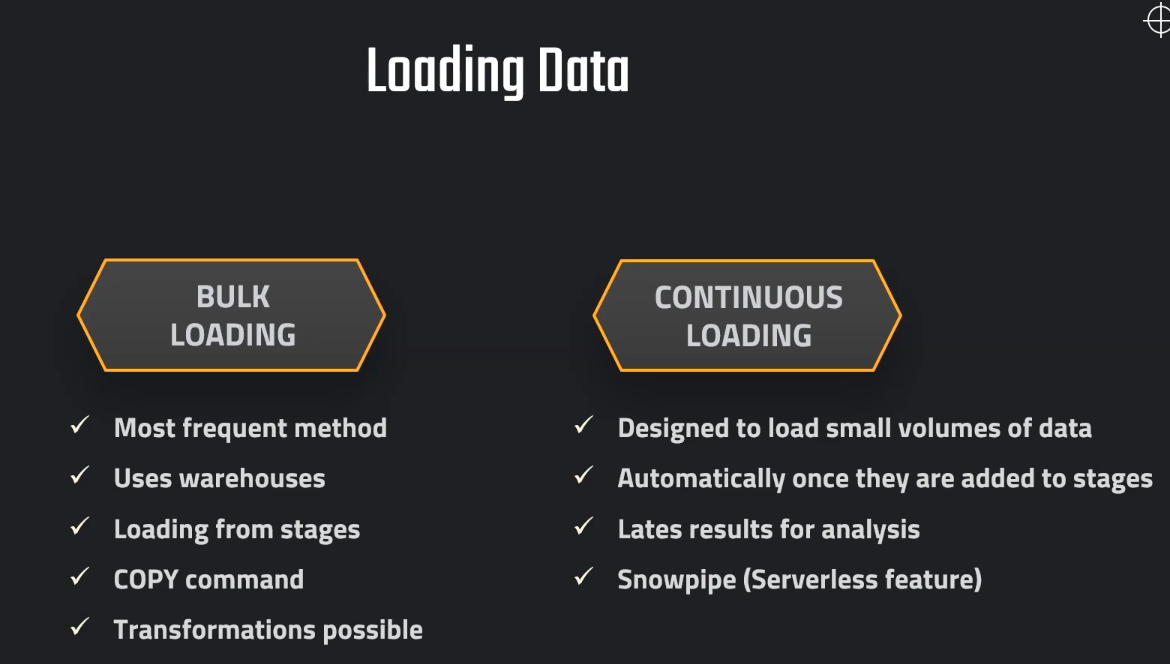

## **26. Understanding Stages**
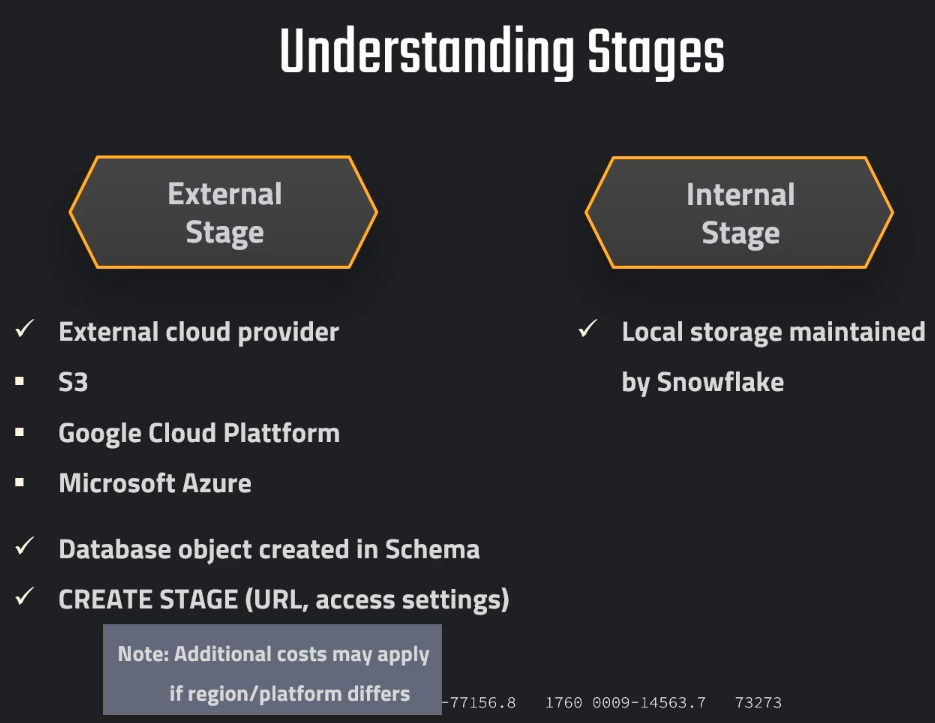

In [ ]:
## **27. Creating Stage**
// Database to manage stage objects, fileformats etc.

CREATE OR REPLACE DATABASE MANAGE_DB;
CREATE OR REPLACE SCHEMA external_stages;


// Creating external stage

CREATE OR REPLACE STAGE MANAGE_DB.external_stages.aws_stage
    url='s3://bucketsnowflakes3'
    credentials=(aws_key_id='ABCD_DUMMY_ID' aws_secret_key='1234abcd_key');


// Description of external stage

DESC STAGE MANAGE_DB.external_stages.aws_stage; 
    
    
// Alter external stage   

ALTER STAGE aws_stage
    SET credentials=(aws_key_id='XYZ_DUMMY_ID' aws_secret_key='987xyz');
    
    
// Publicly accessible staging area    

CREATE OR REPLACE STAGE MANAGE_DB.external_stages.aws_stage
    url='s3://bucketsnowflakes3';

// List files in stage

LIST @aws_stage;

//Load data using copy command

COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS
    FROM @aws_stage
    file_format= (type = csv field_delimiter=',' skip_header=1)
    pattern='.*Order.*';

## **28. COPY command**
// Creating ORDERS table

CREATE OR REPLACE TABLE OUR_FIRST_DB.PUBLIC.ORDERS (
    ORDER_ID VARCHAR(30),
    AMOUNT INT,
    PROFIT INT,
    QUANTITY INT,
    CATEGORY VARCHAR(30),
    SUBCATEGORY VARCHAR(30));
    
SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS;
   
// First copy command

COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS
    FROM @aws_stage
    file_format = (type = csv field_delimiter=',' skip_header=1);




// Copy command with fully qualified stage object

COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS
    FROM @MANAGE_DB.external_stages.aws_stage
    file_format= (type = csv field_delimiter=',' skip_header=1);


// List files contained in stage

LIST @MANAGE_DB.external_stages.aws_stage;    


// Copy command with specified file(s)

COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS
    FROM @MANAGE_DB.external_stages.aws_stage
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files = ('OrderDetails.csv');
    



// Copy command with pattern for file names

COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS
    FROM @MANAGE_DB.external_stages.aws_stage
    file_format= (type = csv field_delimiter=',' skip_header=1)
    pattern='.*Order.*';


In [ ]:
## **29. Transforming data**

// Transforming using the SELECT statement

COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM (select s.$1, s.$2 from @MANAGE_DB.external_stages.aws_stage s)
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files=('OrderDetails.csv');



// Example 1 - Table

CREATE OR REPLACE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX (
    ORDER_ID VARCHAR(30),
    AMOUNT INT
    );
   
   
SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;
   
// Example 2 - Table    
CREATE OR REPLACE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX (
    ORDER_ID VARCHAR(30),
    AMOUNT INT,
    PROFIT INT,
    PROFITABLE_FLAG VARCHAR(30)
  
    );


// Example 2 - Copy Command using a SQL function (subset of functions available)

COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM (select 
            s.$1,
            s.$2, 
            s.$3,
            CASE WHEN CAST(s.$3 as int) < 0 THEN 'not profitable' ELSE 'profitable' END 
          from @MANAGE_DB.external_stages.aws_stage s)
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files=('OrderDetails.csv');


SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;


// Example 3 - Table

CREATE OR REPLACE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX (
    ORDER_ID VARCHAR(30),
    AMOUNT INT,
    PROFIT INT,
    CATEGORY_SUBSTRING VARCHAR(5)
    );


// Example 3 - Copy Command using a SQL function (subset of functions available)

COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM (select 
            s.$1,
            s.$2, 
            s.$3,
            substring(s.$5,1,5) 
          from @MANAGE_DB.external_stages.aws_stage s)
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files=('OrderDetails.csv');


SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;

In [ ]:
### **30. Additional Transforming technique**

//Example 3 - Table

CREATE OR REPLACE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX (
    ORDER_ID VARCHAR(30),
    AMOUNT INT,
    PROFIT INT,
    PROFITABLE_FLAG VARCHAR(30)
  
    );

//Example 4 - Using subset of columns

COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX (ORDER_ID,PROFIT)
    FROM (select 
            s.$1,
            s.$3
          from @MANAGE_DB.external_stages.aws_stage s)
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files=('OrderDetails.csv');

SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;



//Example 5 - Table Auto increment
CREATE OR REPLACE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX (
    ORDER_ID number autoincrement start 1 increment 1,
    AMOUNT INT,
    PROFIT INT,
    PROFITABLE_FLAG VARCHAR(30)
  
    );



//Example 5 - Auto increment ID
COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX (PROFIT,AMOUNT)
    FROM (select 
            s.$2,
            s.$3
          from @MANAGE_DB.external_stages.aws_stage s)
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files=('OrderDetails.csv');


SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX WHERE ORDER_ID > 15;
DROP TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX;


In [ ]:
### **31. Copy options : ON_ERROR**
// Create new stage
 CREATE OR REPLACE STAGE MANAGE_DB.external_stages.aws_stage_errorex
    url='s3://bucketsnowflakes4';
 
 // List files in stage
 LIST @MANAGE_DB.external_stages.aws_stage_errorex;
 
 
 // Create example table
 CREATE OR REPLACE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX (
    ORDER_ID VARCHAR(30),
    AMOUNT INT,
    PROFIT INT,
    QUANTITY INT,
    CATEGORY VARCHAR(30),
    SUBCATEGORY VARCHAR(30));
 
 // Demonstrating error message
COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM @MANAGE_DB.external_stages.aws_stage_errorex
     file_format= (type = csv field_delimiter=',' skip_header=1)
     files = ('OrderDetails_error.csv');
    

 // Validating table is empty    
SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX  ;  
    

  // Error handling using the ON_ERROR option
COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM @MANAGE_DB.external_stages.aws_stage_errorex
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files = ('OrderDetails_error.csv')
    ON_ERROR = 'CONTINUE';
    
  // Validating results and truncating table 
SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;
SELECT COUNT(*) FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;

TRUNCATE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX;

// Error handling using the ON_ERROR option = ABORT_STATEMENT (default)
COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM @MANAGE_DB.external_stages.aws_stage_errorex
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files = ('OrderDetails_error.csv','OrderDetails_error2.csv')
    ON_ERROR = 'ABORT_STATEMENT';


  // Validating results and truncating table 
SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;
SELECT COUNT(*) FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;

TRUNCATE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX;

// Error handling using the ON_ERROR option = SKIP_FILE
COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM @MANAGE_DB.external_stages.aws_stage_errorex
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files = ('OrderDetails_error.csv','OrderDetails_error2.csv')
    ON_ERROR = 'SKIP_FILE';
    
    
  // Validating results and truncating table 
SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;
SELECT COUNT(*) FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;

TRUNCATE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX;    
    

// Error handling using the ON_ERROR option = SKIP_FILE_<number>
COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM @MANAGE_DB.external_stages.aws_stage_errorex
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files = ('OrderDetails_error.csv','OrderDetails_error2.csv')
    ON_ERROR = 'SKIP_FILE_2';    
    
    
  // Validating results and truncating table 
SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;
SELECT COUNT(*) FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;

TRUNCATE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX;    

    
// Error handling using the ON_ERROR option = SKIP_FILE_<number>
COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM @MANAGE_DB.external_stages.aws_stage_errorex
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files = ('OrderDetails_error.csv','OrderDetails_error2.csv')
    ON_ERROR = 'SKIP_FILE_3%'; 
  
  
SELECT * FROM OUR_FIRST_DB.PUBLIC.ORDERS_EX;


 CREATE OR REPLACE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX (
    ORDER_ID VARCHAR(30),
    AMOUNT INT,
    PROFIT INT,
    QUANTITY INT,
    CATEGORY VARCHAR(30),
    SUBCATEGORY VARCHAR(30));





COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM @MANAGE_DB.external_stages.aws_stage_errorex
    file_format= (type = csv field_delimiter=',' skip_header=1)
    files = ('OrderDetails_error.csv','OrderDetails_error2.csv')
    ON_ERROR = SKIP_FILE_3 
    SIZE_LIMIT = 30;

In [ ]:
### **32. File Format Object**

// Specifying file_format in Copy command
COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM @MANAGE_DB.external_stages.aws_stage_errorex
    file_format = (type = csv field_delimiter=',' skip_header=1)
    files = ('OrderDetails_error.csv')
    ON_ERROR = 'SKIP_FILE_3'; 
    
// Creating table
CREATE OR REPLACE TABLE OUR_FIRST_DB.PUBLIC.ORDERS_EX (
    ORDER_ID VARCHAR(30),
    AMOUNT INT,
    PROFIT INT,
    QUANTITY INT,
    CATEGORY VARCHAR(30),
    SUBCATEGORY VARCHAR(30));    
    
// Creating schema to keep things organized
CREATE OR REPLACE SCHEMA MANAGE_DB.file_formats;

// Creating file format object
CREATE OR REPLACE file format MANAGE_DB.file_formats.my_file_format;

// See properties of file format object
DESC file format MANAGE_DB.file_formats.my_file_format;


// Using file format object in Copy command       
COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM @MANAGE_DB.external_stages.aws_stage_errorex
    file_format= (FORMAT_NAME=MANAGE_DB.file_formats.my_file_format)
    files = ('OrderDetails_error.csv')
    ON_ERROR = 'SKIP_FILE_3'; 


// Altering file format object
ALTER file format MANAGE_DB.file_formats.my_file_format
    SET SKIP_HEADER = 1;
    
// Defining properties on creation of file format object   
CREATE OR REPLACE file format MANAGE_DB.file_formats.my_file_format
    TYPE=JSON,
    TIME_FORMAT=AUTO;    
    
// See properties of file format object    
DESC file format MANAGE_DB.file_formats.my_file_format;   

  
// Using file format object in Copy command       
COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM @MANAGE_DB.external_stages.aws_stage_errorex
    file_format= (FORMAT_NAME=MANAGE_DB.file_formats.my_file_format)
    files = ('OrderDetails_error.csv')
    ON_ERROR = 'SKIP_FILE_3'; 


// Altering the type of a file format is not possible
ALTER file format MANAGE_DB.file_formats.my_file_format
SET TYPE = CSV;


// Recreate file format (default = CSV)
CREATE OR REPLACE file format MANAGE_DB.file_formats.my_file_format;


// See properties of file format object    
DESC file format MANAGE_DB.file_formats.my_file_format;   



// Truncate table
TRUNCATE table OUR_FIRST_DB.PUBLIC.ORDERS_EX;



// Overwriting properties of file format object      
COPY INTO OUR_FIRST_DB.PUBLIC.ORDERS_EX
    FROM  @MANAGE_DB.external_stages.aws_stage_errorex
    file_format = (FORMAT_NAME= MANAGE_DB.file_formats.my_file_format  field_delimiter = ',' skip_header=1 )
    files = ('OrderDetails_error.csv')
    ON_ERROR = 'SKIP_FILE_3'; 

DESC STAGE MANAGE_DB.external_stages.aws_stage_errorex;


In [ ]:
### **33. Summary**